# Wrap
From these CFOSAT-derived estimates of DirP and Tp, linear dispersion relationship can then be exploited to predict arrival times and locations of the swell.

"Monitoring and analysis of ocean swell fields from space: New methods for routine observations" <br>
Fabrice Collard, Fabrice Ardhuin, and Bertrand Chapron3 <br>


* The peak directions are used to project the peak periods in one dimension along the corresponding great circle route, both forward and back in time, using the peak period group velocity

Storm Source Identification and ‘‘Fireworks’’<br>
Using backward trajectories, the location and date of
swell sources can further be defined as the spatial and
temporal center of the convergence area and time of the
trajectories. 

In [ ]:
ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))

In [ ]:
ds_ww3 = xr.open_dataset(op.join(p_output, 'ww3_dataset.nc'))

In [4]:
ds_params = xr.open_dataset(op.join(p_output, 'params_output_Hs.nc'))
ds_part_CFOSAT = xr.open_dataset(op.join(p_output, 'partitions_CFOSAT.nc'))

## Storage files for each track

In [ ]:
for pfile, file in enumerate(ds_data.file.values):
    #try:
    sys.stdout.write('\r File number: {0}\{1}'.format(pfile,len(ds_data.file.values)))
    sys.stdout.flush()

    dsf = ds_data.isel(file=pfile).dropna(dim='nbox')
    ds_params_freqs = wrapSpectra.compute_spectra(dsf, file, ds_ww3, beam, 
                                                            min_wavelength, max_wavelength)
    #ds_params_freqs.to_netcdf(op.join(p_output, 'process_FilesFreq', 'F{0}_.nc'.format(pfile)))
#except:
    print(pfile)
    break

## Calculate Hs, T, C, Ttime

In [24]:
ds = xr.open_mfdataset(glob.glob(op.join(p_output, 'process_FilesFreq', '*')),
                       engine='netcdf4', combine='nested', concat_dim='file', parallel=True)


In [41]:
ds.to_netcdf(op.join(p_output, 'params_output.nc'))

In [5]:
ds = xr.open_dataset(op.join(p_output, 'params_output.nc'))

In [6]:
g = 9.806
rad_ang = 15*(2*pi)/360
dk = np.diff(np.append(0, ds.k))

dataset = xr.Dataset()
for pfile, file in enumerate(ds.file):
    sys.stdout.write('\r File number: {0}\{1}'.format(pfile,len(ds_data.file.values)))
    sys.stdout.flush()
    
    dsi = ds.isel(file=pfile).load()
    
    # wavelength, period, celerity
    wl = 2*np.pi/dsi.k
    T = np.sqrt(2*np.pi*wl/g)
    C = g*T/(2*np.pi)
            
    Ttime = (dsi.distance/C)

    dsi = dsi.assign(H=4*np.sqrt(((dsi.efth/dsi.k)*rad_ang)*(dk)))
    dsi = dsi.assign(T=T)
    dsi = dsi.assign(Ttime=Ttime) 

    dsi = dsi.drop(['longitude', 'latitude', 'bearing1']).expand_dims('file')
    dataset = xr.merge([dataset, dsi])
    

 File number: 117\138

In [8]:
dataset.to_netcdf(op.join(p_output, 'params_freqs_output.nc'))

In [6]:
dataset = xr.open_dataset(op.join(p_output, 'params_freqs_output.nc'))

## Plot daily arriving energy 

In [7]:
ds = ds.isel(file=slice(0,len(dataset.file)))

In [8]:
# Convert dataset to dataframe
ds_HTtime = dataset[['Ttime','H', 'T']]
ds_lonlat = ds[['longitude', 'latitude', 'bearing1']]
ds_coor_Ttime = xr.merge([ds_HTtime, ds_lonlat])
df_coor_Ttime = ds_coor_Ttime.to_dataframe().dropna()


In [9]:
days = 5
th = 0.1

df_iT = df_coor_Ttime.loc[df_coor_Ttime.Ttime < 86400*days].reset_index()
df_iT['EF'] = (df_iT['H']**2)*df_iT['T']
df_iT = df_iT.loc[df_iT.H > th]

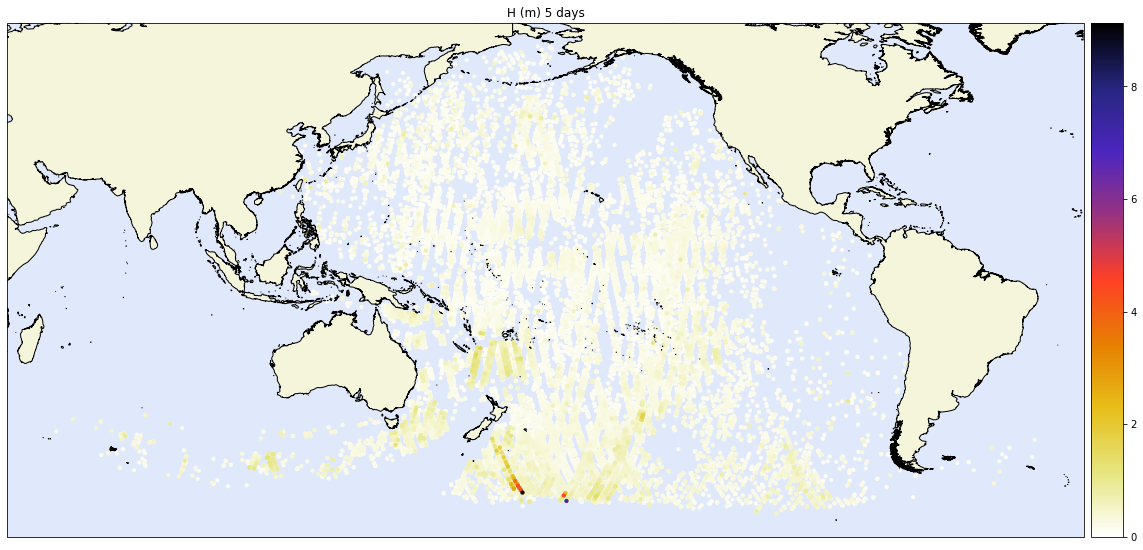

In [10]:
var = 'H'
df_iT = df_iT.sort_values('H')
vmax = np.max([np.nanmax(np.abs(df_iT[var].values)),
               np.nanmax(np.abs(df_iT[var].values))])

figsize=(20,10)
title = 'H (m) {0} days'.format(days)
cmap = 'CMRmap_r'
vmin, vmax = 0, vmax
fig, ax = plot_sat.attrs_map(
                            df_iT.longitude.values, 
                            df_iT.latitude.values, 
                            df_iT[var].values, figsize, title,
                            cmap, vmin, vmax
)

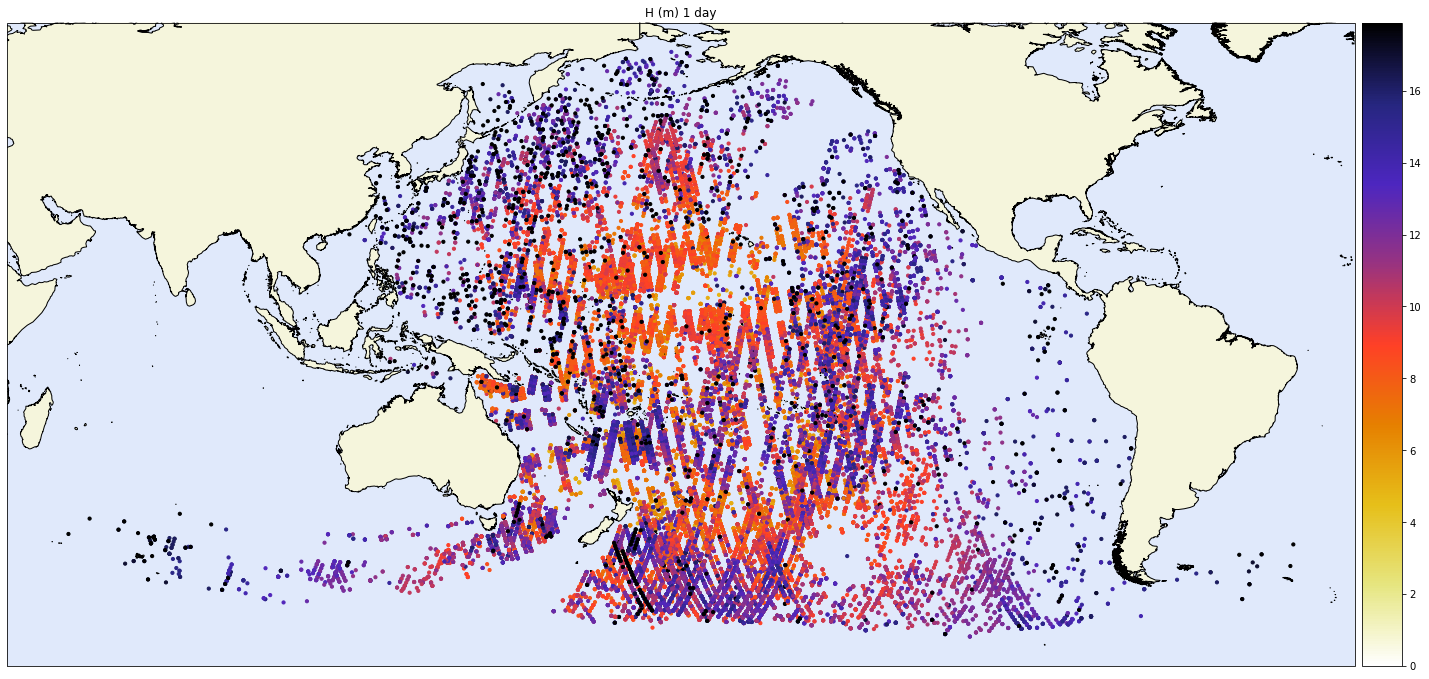

In [11]:
var = 'T'
df_iT = df_iT.sort_values('EF')
vmax = np.max([np.nanmax(np.abs(df_iT[var].values)),
               np.nanmax(np.abs(df_iT[var].values))])

figsize=(25,15)
title = 'H (m) 1 day'
cmap = 'CMRmap_r'
vmin, vmax = 0, vmax
fig, ax = plot_sat.attrs_map(
                            df_iT.longitude.values, 
                            df_iT.latitude.values, 
                            df_iT[var].values, figsize, title,
                            cmap, vmin, vmax
)

## Snakes

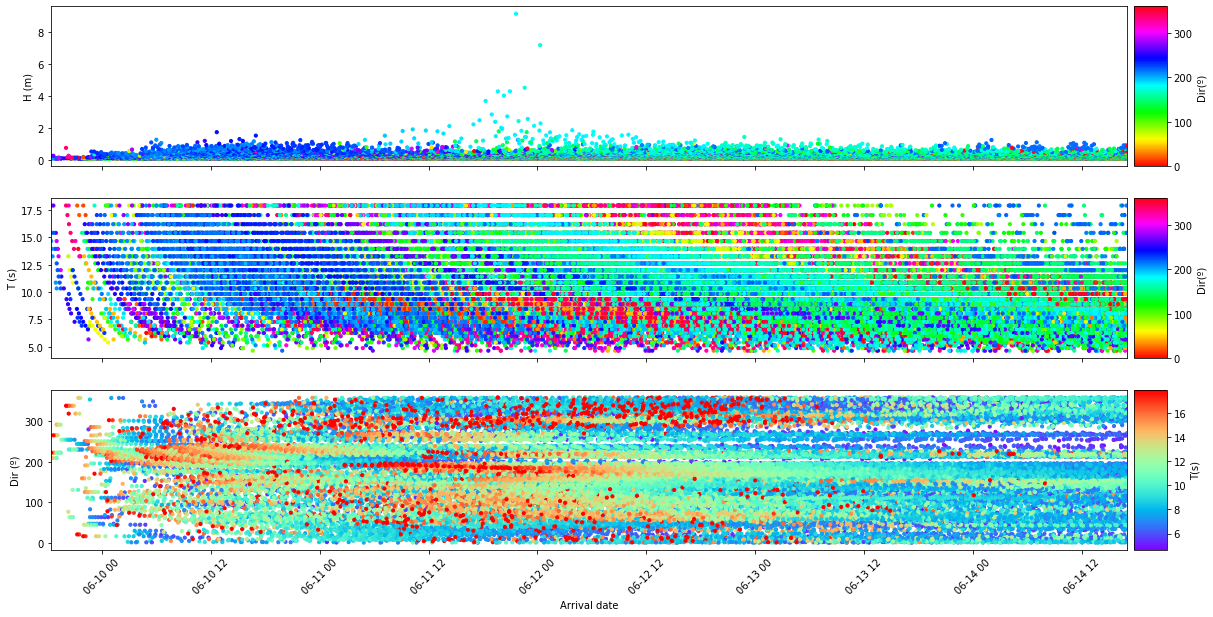

In [17]:
import matplotlib.pyplot as plt
cmap='rainbow'

fig, axs = plt.subplots(3,1,figsize=(20,10), sharex=True)

# arrays
df_date = pd.DataFrame([datetime.timedelta(seconds=i) + datetime.datetime.now() for i in df_iT.Ttime.values])
df_iT['date'] = df_date[0].values
df_iT = df_iT.sort_values('H')

# Time - Hs
im0 = axs[0].scatter(df_iT.date.values, df_iT.H.values, c=df_iT['bearing1'].values, s=10, cmap='hsv')
# Time - T
im1 = axs[1].scatter(df_iT.date.values, df_iT['T'].values, c=df_iT['bearing1'].values, s=10, cmap='hsv')
# Time - Dir
im2 = axs[2].scatter(df_iT.date.values, df_iT['bearing1'].values, c=df_iT['T'].values, s=10, cmap=cmap)


# axis
axs[0].set_xlim(df_date.values.min(), df_date.values.max())
axs[0].set_ylabel('H (m)')
axs[1].set_ylabel('T (s)')
axs[2].set_ylabel('Dir (º)')
axs[2].set_xlabel('Arrival date')
plt.xticks(rotation=45)
    
# colorbar
axc0, loc = plot_sat.add_colorbar(axs[0])
axc1, loc = plot_sat.add_colorbar(axs[1])
axc2, loc = plot_sat.add_colorbar(axs[2])

fig.add_axes(axc0)
fig.add_axes(axc1)
fig.add_axes(axc2)

plt.colorbar(im0,  cax=axc0, label='Dir(º)')
plt.colorbar(im1,  cax=axc1, label='Dir(º)')
plt.colorbar(im2,  cax=axc2, label='T(s)')
plt.show() 
